In [12]:
import sys, os, csv, re, math, cv2, random, torch

import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import numba
import louvain
import scipy
import natsort
import sklearn
import igraph
from scipy.sparse import issparse
from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.colors as clr
import matplotlib.pyplot as plt

In [13]:
import __init__ as Spa3D

In [14]:
print("Spa3D version: " + Spa3D.__version__)
print("python version: " + sys.version)
print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("numba version: " + numba.__version__)
print("python-igraph: " + igraph.__version__)
print("torch version: " + torch.__version__)
print("louvain version: " + louvain.__version__)
print("scipy version: " + scipy.__version__)
print("scanpy version: " + sc.__version__)
print("anndata version: " + ad.__version__)
print("natsort version: " + natsort.__version__)
print("sklearn version: " + sklearn.__version__)

Spa3D version: Spa3D-1.0
python version: 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
pandas version: 1.3.4
numpy version: 1.20.1
numba version: 0.53.1
python-igraph: 0.9.8
torch version: 1.10.0+cu102
louvain version: 0.7.1
scipy version: 1.6.2
scanpy version: 1.8.2
anndata version: 0.7.8
natsort version: 8.0.0
sklearn version: 0.24.1


In [15]:
adata = sc.read("data/adata3D_week6_four_spe.h5ad")

In [16]:
adata.var_names_make_unique()
Spa3D.preprocessing_filter_by_gene_number(adata,min_cells=3)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [17]:
x_array = adata.obs["x_array"].tolist()
y_array = adata.obs["y_array"].tolist()
z_array = adata.obs["z_array"].tolist()
x_pixel = adata.obs["x_pixel_aligned"].tolist()
y_pixel = adata.obs["y_pixel_aligned"].tolist()
z_pixel = adata.obs["z_pixel"].tolist()

p = 0.5
start = 0.01
end = 200
num_clusters = 5
num_neighbors = 20
r_seed = t_seed = n_seed = 100

In [18]:
adj3d = Spa3D.calculate_adj_matrix_3D(x = x_pixel, y = y_pixel, m = z_pixel)
decay_value = Spa3D.search_decay_value_3D(adj3d, p = p, start = start, end = end)
resolution = Spa3D.search_proper_resolution_3D(adata, adj3d, decay_value, num_clusters = num_clusters, num_neighbors = num_neighbors, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

Calculateing adj matrix using xyz only...
Iteration ID: 1: decay_value [0.01, 200], p [0.0, 13.929758614917239]
Iteration ID: 2: decay_value [0.01, 100.005], p [0.0, 2.125054359436035]
Iteration ID: 3: decay_value [50.0075, 100.005], p [0.27549946308135986, 2.125054359436035]
Iteration ID: 4: decay_value [50.0075, 75.00625], p [0.27549946308135986, 0.8396320343017578]
Iteration ID: 5: decay_value [62.506874999999994, 75.00625], p [0.4912031888961792, 0.8396320343017578]
Iteration ID: 6: decay_value [62.506874999999994, 68.7565625], p [0.4912031888961792, 0.6444849967956543]
Iteration ID: 7: decay_value [62.506874999999994, 65.63171875], p [0.4912031888961792, 0.5631132125854492]
Iteration ID: 8: decay_value [62.506874999999994, 64.06929687499999], p [0.4912031888961792, 0.5260454416275024]
Iteration ID: 9: decay_value [62.506874999999994, 63.28808593749999], p [0.4912031888961792, 0.5083550214767456]
Iteration ID: 10: decay_value [62.89748046874999, 63.28808593749999], p [0.49971282482

In [19]:
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

clf = Spa3D.Spa3D()
clf.set_l(decay_value)
clf.train(adata, adj3d, init_spa = True,init = "louvain",res = resolution, tol=5e-16, lr=0.05, num_neighbors=num_neighbors, max_epochs=2000)
y_pred, prob, pca=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')


Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
delta_label  0.0 < tol  5e-16
Reach tolerance threshold. Stopping training.
Total epoch: 52


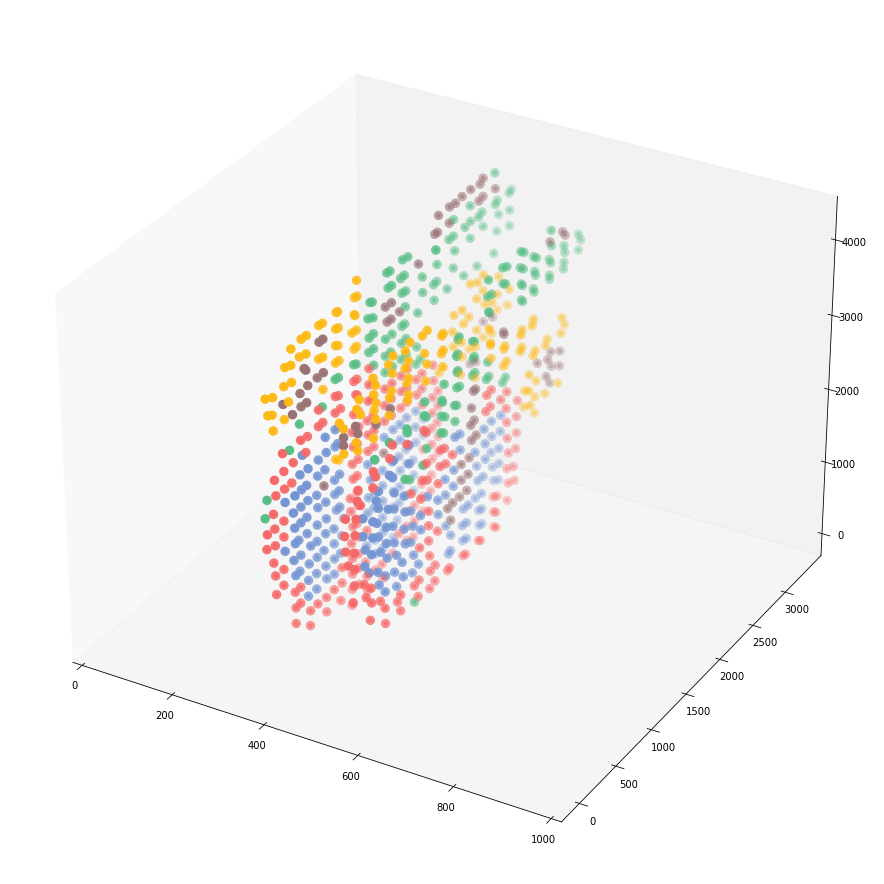

In [11]:
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]
x_array = adata.obs["x_array"]
y_array = adata.obs["y_array"]
z_array = 12 - adata.obs["z_array"]
z_array_cluster = set(z_array.to_list())
x_pixel = adata.obs["x_pixel_aligned"]
y_pixel = adata.obs["y_pixel_aligned"]
z_pixel = adata.obs["z_pixel"]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.grid(False)

dict_x_pixel = {}
dict_y_pixel = {}
dict_z_array = {}
dict_z_pixel = {}
pred = adata.obs["pred"].to_numpy()
cluster = set(pred)
#plt.axis('off')

ax.set_xlim3d(0, 1000)

for j in z_array_cluster:
    
    i = 0

    for id in cluster:
        dict_x_pixel[id] = x_pixel[(pred == id) & (z_array == j)].tolist()
        dict_y_pixel[id] = y_pixel[(pred == id) & (z_array == j)].tolist()
        dict_z_pixel[id] = z_pixel[(pred == id) & (z_array == j)].tolist()
        # ax.axes.invert_yaxis()
        ax.scatter(dict_z_pixel[id], dict_x_pixel[id],dict_y_pixel[id], c=plot_color[i], linewidths = 5.0)
        i = i + 1

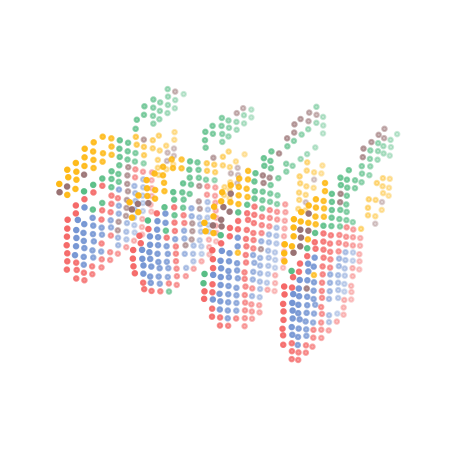

In [12]:
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]
x_array = adata.obs["x_array"]
y_array = adata.obs["y_array"]
z_array = 12 - adata.obs["z_array"]
z_array_cluster = set(z_array.to_list())
x_pixel = adata.obs["x_pixel_aligned"]
y_pixel = adata.obs["y_pixel_aligned"]
z_pixel = adata.obs["z_pixel"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.grid(False)

dict_x_pixel = {}
dict_y_pixel = {}
dict_z_array = {}
pred = adata.obs["pred"].to_numpy()
cluster = set(pred)
plt.axis('off')

for j in z_array_cluster:
    
    i = 0

    for id in cluster:
        dict_x_pixel[id] = x_pixel[(pred == id) & (z_array == j)].tolist()
        dict_y_pixel[id] = y_pixel[(pred == id) & (z_array == j)].tolist()
        dict_z_array[id] = z_array[(pred == id) & (z_array == j)].tolist()
        # ax.axes.invert_yaxis()
        ax.scatter(dict_z_array[id], dict_x_pixel[id],dict_y_pixel[id], c=plot_color[i], linewidths = 2.0)
        i = i + 1

In [14]:
adata.obs["annotation2"] = adata.obs["annotation"]

domains="annotation2"
b = adata.obs[domains].to_numpy()
n = len(b)
print(n)
for i in range(n):
    if b[i] == 0:
        b[i] = 0
    elif b[i] == 1:
        b[i] = 1
    elif b[i] == 2:
        b[i] = 1
    elif b[i] == 3:
        b[i] = 1
    elif b[i] == 4:
        b[i] = 2
    elif b[i] == 5:
        b[i] = 3
    elif b[i] == 6:
        b[i] = 3
    elif b[i] == 7:
        b[i] = 3
    elif b[i] == 8:
        b[i] = 4
    elif b[i] == 9:
        b[i] = 0
    else:
        b[i] = 0
        
b = b.astype(int)

adata.obs[domains] = b

783


In [15]:
domains1="pred"
domains2="annotation2"
a = adata.obs[domains1].to_numpy()
b = adata.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)

0.48484786237567534

Trying to set attribute `._uns` of view, copying.
/home/chentang/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


0.43720977539911127

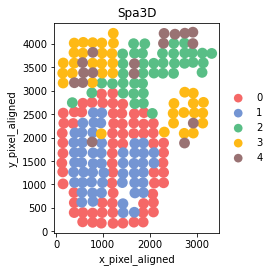

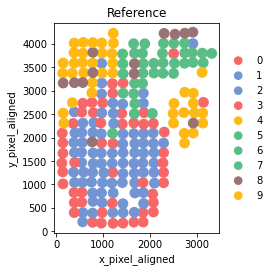

In [16]:
adata_sub = adata[adata.obs['z_array'].isin([9]),:]
#Set colors used
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]

#Plot spatial domains
domains="pred"
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Spa3D",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

plot_color=["#F56867","#7495D3","#7495D3","#F56867","#FEB915","#59BE86","#59BE86","#59BE86","#997273","#FEB915"]

#Plot refined spatial domains
domains="annotation"
adata_sub.obs[domains] = adata_sub.obs[domains].astype(str)
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Reference",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

domains1="pred"
domains2="annotation2"
a = adata_sub.obs[domains1].to_numpy()
b = adata_sub.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)


Trying to set attribute `._uns` of view, copying.
/home/chentang/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


0.45073814857524613

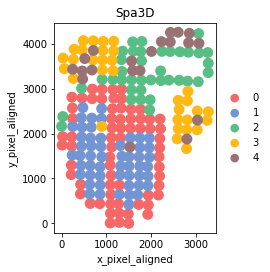

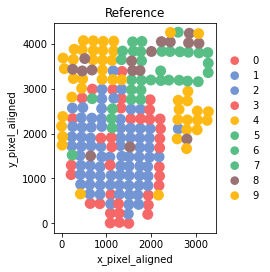

In [17]:
adata_sub = adata[adata.obs['z_array'].isin([10]),:]
#Set colors used
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]

#Plot spatial domains
domains="pred"
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Spa3D",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

plot_color=["#F56867","#7495D3","#7495D3","#F56867","#FEB915","#59BE86","#59BE86","#59BE86","#997273","#FEB915"]

#Plot refined spatial domains
domains="annotation"
adata_sub.obs[domains] = adata_sub.obs[domains].astype(str)
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Reference",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

domains1="pred"
domains2="annotation2"
a = adata_sub.obs[domains1].to_numpy()
b = adata_sub.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)


Trying to set attribute `._uns` of view, copying.
/home/chentang/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


0.5746463907347432

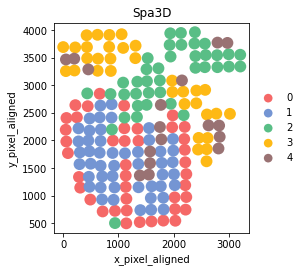

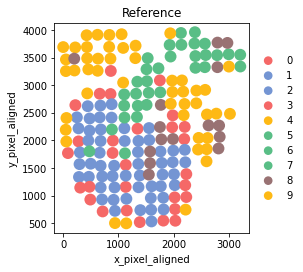

In [18]:
adata_sub = adata[adata.obs['z_array'].isin([11]),:]
#Set colors used
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]

#Plot spatial domains
domains="pred"
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Spa3D",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

plot_color=["#F56867","#7495D3","#7495D3","#F56867","#FEB915","#59BE86","#59BE86","#59BE86","#997273","#FEB915"]

#Plot refined spatial domains
domains="annotation"
adata_sub.obs[domains] = adata_sub.obs[domains].astype(str)
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Reference",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

domains1="pred"
domains2="annotation2"
a = adata_sub.obs[domains1].to_numpy()
b = adata_sub.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)


Trying to set attribute `._uns` of view, copying.
/home/chentang/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


0.479732066149517

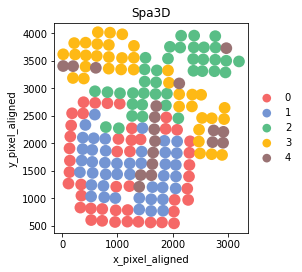

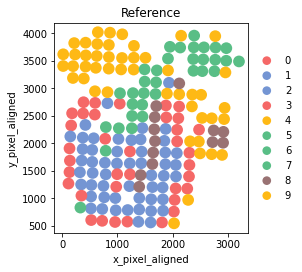

In [19]:
adata_sub = adata[adata.obs['z_array'].isin([12]),:]
#Set colors used
plot_color=["#F56867","#7495D3","#59BE86","#FEB915","#997273"]

#Plot spatial domains
domains="pred"
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Spa3D",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

plot_color=["#F56867","#7495D3","#7495D3","#F56867","#FEB915","#59BE86","#59BE86","#59BE86","#997273","#FEB915"]

#Plot refined spatial domains
domains="annotation"
adata_sub.obs[domains] = adata_sub.obs[domains].astype(str)
num_celltype=len(adata_sub.obs[domains].unique())
adata_sub.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata_sub,alpha=1,y="y_pixel_aligned",x="x_pixel_aligned",color=domains,title="Reference",color_map=plot_color,show=False,size=100000/adata_sub.shape[0])
ax.set_aspect('equal', 'box')
#ax.axes.invert_yaxis()
#plt.savefig(pred_pngfilename, dpi=600)
#plt.close()

domains1="pred"
domains2="annotation2"
a = adata_sub.obs[domains1].to_numpy()
b = adata_sub.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)
